## Components of a DL Project

1. Dataset (CIFAR, MNIST etc)
2. Model (CNN, RNN etc)
3. Objective function (Cross entropy, MSE loss etc)
4. Optimizer (SGD, RMSProp, Adam, Adagrad etc)

# Dataset

In [1]:
#a Tensor library with GPU support
import os, sys
sys.path.append('./src')
import torch

# Dataset download and extraction routines
import data_tools

#Datasets, Transforms and Models specific to Computer Vision
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sampler import ImbalancedDatasetSampler

####train data
#Compose transforms (applies data transformation and augmentation) prior to feeding to training
transform = transforms.Compose(
    [transforms.Resize((64, 64)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# download data
train_imgs_path, test_imgs_path = data_tools.GTSRB()

trainset = ImageFolder(root=train_imgs_path, transform=transform)
testset = ImageFolder(root=test_imgs_path, transform=transform)
print("train : " + str(len(trainset)) + ' images')
print("test : " + str(len(testset)) + ' images')
print("image size : ", testset[0][0].size())

trainloader = DataLoader(dataset=trainset, batch_size=64, 
                          sampler=ImbalancedDatasetSampler(trainset, num_samples=15000), drop_last=False)
testloader = DataLoader(dataset=testset, batch_size=8, 
                         sampler=ImbalancedDatasetSampler(testset, num_samples=2000), drop_last=False)

file ./data/train.zip already exists
file ./data/test.zip already exists
file ./data/test_gt.zip already exists
unzipping ./data/train.zip
unzipping ./data/test.zip
unzipping ./data/test_gt.zip
train : 39209 images
test : 12630 images
image size :  torch.Size([3, 64, 64])


#### Visualizing the dataset images

tensor([12, 15,  9, 30, 29, 40, 19, 35])


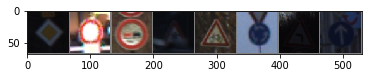

In [2]:
#plotting and visualization library
import matplotlib.pyplot as plt
#Display on the notebook
%matplotlib inline 
plt.ion() #Turn interactive mode on.

#scientific computing library for Python
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print(labels)

# Simple network

![cifarnet](./pics/CIFAR_CNN.png)

# Model

In [3]:
#a neural networks library integrated with autograd functionality
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    
    #define the learnable paramters by calling the respective modules (nn.Conv2d, nn.MaxPool2d etc.)
    def __init__(self):
        super(Net, self).__init__()
        
        #calling conv2d module for convolution
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, 
                               kernel_size=7, stride=1,
                               padding=0,bias=True)
        
        #calling MaxPool2d module for max pooling with downsampling of 2
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(6, 16, 7)
        #calling MaxPool2d module for max pooling with downsampling of 2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(16, 16, 7)
        
        #fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 43)
    
    #defining the structure of the network
    def forward(self, x):
        
        #Applying relu activation after each conv layer
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        
        #reshaping to 1d for giving input to fully connected units
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

#Printing the network architecture
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(7, 7), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(7, 7), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=43, bias=True)
)


#### Forward Pass

In [4]:
input = torch.randn(1, 3, 64, 64)
out = net(input)
print(out)

tensor([[ 0.0545,  0.0236, -0.0493, -0.0268, -0.0513,  0.0158, -0.1011, -0.1110,
         -0.0171,  0.0271, -0.0172,  0.0180,  0.0212,  0.0291,  0.0972, -0.0076,
         -0.0172, -0.0523,  0.0469,  0.0787,  0.0339,  0.0653, -0.0806, -0.0260,
          0.0569,  0.0434, -0.0284, -0.0255, -0.0245, -0.0832, -0.1289, -0.0526,
          0.1001, -0.0495, -0.0942,  0.0755,  0.0383,  0.0607, -0.0369,  0.0179,
          0.0170, -0.0221,  0.0365]], grad_fn=<AddmmBackward>)


#### Backward Pass

In [5]:
net.zero_grad()
out.backward(torch.randn(1, 43))

#### Loss Function
In this example, we will use Classification Cross-Entropy loss and SGD with momentum.<br>
Cross Entropy loss is given as:- $L=-\sum_i y_i \log(p_i)$ and $p_i=\frac{\exp^{x_i}}{\sum_k \exp^{x_k}}$

There are many other loss functions such as MSELoss, L1Loss etc. Visit [here](http://pytorch.org/docs/master/nn.html#loss-functions) for other loss functions.

In [6]:
criterion = nn.CrossEntropyLoss()
print(criterion)

CrossEntropyLoss()



#### Stochastic Gradient Descent (SGD)
$$w_{n+1} = w_{n} - \eta \triangle$$
$$\triangle = 0.9\triangle + \frac{\partial L}{\partial w}$$

Although SGD is the most popular and basic optimizer that one should first try. There are many adaptive optimizers like Adagrad,Adadelta RMSProp and many more. Visit [here](http://pytorch.org/docs/master/optim.html) for other examples.

In [7]:
#an optimization package with standard optimization methods such as SGD, RMSProp, LBFGS, Adam etc.
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

#### Training in mini-batches

In [8]:
########################################################################
# Train the network
# ^^^^^^^^^^^^^^^^^^^^

def train(epoch, trainloader, optimizer, criterion):
    running_loss = 0.0
    
    for i, data in enumerate(tqdm(trainloader), 0):
        # get the inputs
        inputs, labels = data
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # addup loss
        running_loss += loss.item()

    print('epoch %d training loss: %.3f' %
            (epoch + 1, running_loss / (len(trainloader))))
    return running_loss / (len(trainloader))   

#### Forward Pass over the trained network

expected:  tensor([12, 15,  9, 30, 29, 40, 19, 35])
predicted:  tensor([32, 32, 32, 32, 14, 32, 32, 32])


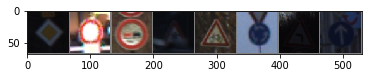

In [9]:
outputs = net(images)
_, predicted = torch.max(outputs.data, 1)

imshow(torchvision.utils.make_grid(images))
print('expected: ', labels)
print('predicted: ', predicted)

### Test Accuracy 

In [10]:
########################################################################
# Let us look at how the network performs on the test dataset.

def test(testloader, model):
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(testloader):
            # get the inputs
            inputs, labels = data
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            # addup loss
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the ' + str(total) + ' test images: %d %%, loss = %f' % (
                                    100 * correct / total, running_loss / len(testloader)))
    return running_loss / len(testloader)


# Train loop

In [11]:
import os
from tqdm import tqdm
print('Start Training')
if not os.path.exists('./models'):
    os.mkdir('./models')

training_losses = []
testing_losses = []
num_epochs = 10


for epoch in range(num_epochs):  # loop over the dataset multiple times
    print('epoch ', epoch + 1)
    train_loss = train(epoch, trainloader, optimizer, criterion)
    test_loss = test(testloader, net)
    torch.save(net.state_dict(), './models/model-'+str(epoch)+'.pth')
    
    training_losses.append(train_loss)
    testing_losses.append(test_loss)

print('Finished Training')



  0%|          | 0/235 [00:00<?, ?it/s]

Start Training
epoch  1


  0%|          | 0/250 [00:00<?, ?it/s]

epoch 1 training loss: 3.751


  0%|          | 0/235 [00:00<?, ?it/s]

Accuracy of the network on the 2000 test images: 4 %, loss = 3.720989
epoch  2


  0%|          | 0/250 [00:00<?, ?it/s]

epoch 2 training loss: 1.867


  0%|          | 0/235 [00:00<?, ?it/s]

Accuracy of the network on the 2000 test images: 66 %, loss = 1.556977
epoch  3


  0%|          | 0/250 [00:00<?, ?it/s]

epoch 3 training loss: 0.437


  0%|          | 0/235 [00:00<?, ?it/s]

Accuracy of the network on the 2000 test images: 80 %, loss = 1.060792
epoch  4


  0%|          | 0/250 [00:00<?, ?it/s]

epoch 4 training loss: 0.229


  0%|          | 0/235 [00:00<?, ?it/s]

Accuracy of the network on the 2000 test images: 87 %, loss = 0.847033
epoch  5


  0%|          | 0/250 [00:00<?, ?it/s]

epoch 5 training loss: 0.151


  0%|          | 0/235 [00:00<?, ?it/s]

Accuracy of the network on the 2000 test images: 88 %, loss = 0.631618
epoch  6


  0%|          | 0/250 [00:00<?, ?it/s]

epoch 6 training loss: 0.117


  0%|          | 0/235 [00:00<?, ?it/s]

Accuracy of the network on the 2000 test images: 88 %, loss = 0.622641
epoch  7


  0%|          | 0/250 [00:00<?, ?it/s]

epoch 7 training loss: 0.085


  0%|          | 0/235 [00:00<?, ?it/s]

Accuracy of the network on the 2000 test images: 86 %, loss = 0.852289
epoch  8


  0%|          | 0/250 [00:00<?, ?it/s]

epoch 8 training loss: 0.077


  0%|          | 0/235 [00:00<?, ?it/s]

Accuracy of the network on the 2000 test images: 89 %, loss = 0.681609
epoch  9


  0%|          | 0/250 [00:00<?, ?it/s]

epoch 9 training loss: 0.062


  0%|          | 0/235 [00:00<?, ?it/s]

Accuracy of the network on the 2000 test images: 86 %, loss = 1.136889
epoch  10


  0%|          | 0/250 [00:00<?, ?it/s]

epoch 10 training loss: 0.062


100%|██████████| 250/250 [01:18<00:00,  3.44it/s]

Accuracy of the network on the 2000 test images: 88 %, loss = 0.776856
Finished Training


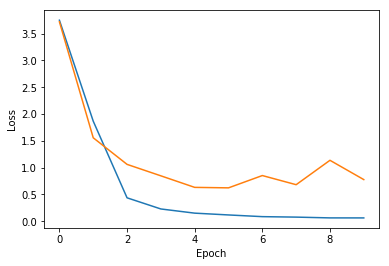

In [12]:
#Plotting the training graph
plt.plot(range(len(training_losses)), training_losses, label="train")
plt.plot(range(len(testing_losses)), testing_losses, label="test")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Test the model

expected:  tensor([12, 15,  9, 30, 29, 40, 19, 35])
predicted:  tensor([12, 15,  9, 30, 29, 42, 19, 35])


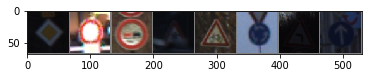

In [13]:
outputs = net(images)
_, predicted = torch.max(outputs.data, 1)

imshow(torchvision.utils.make_grid(images))
print('expected: ', labels)
print('predicted: ', predicted)

## Loading saved model

In [14]:
new_net = Net()
new_net.load_state_dict(torch.load('./models/model-5.pth'))

## Miscellaneous APIs

### To numpy / From numpy

In [15]:
import torch
torch_tensor = torch.rand(3,3)
print(type(torch_tensor))
print(torch_tensor)

<class 'torch.Tensor'>
tensor([[0.3079, 0.0115, 0.1478],
        [0.6904, 0.9578, 0.6197],
        [0.3360, 0.9512, 0.1072]])


In [16]:
import numpy as np
np_array = torch_tensor.numpy()
print(type(np_array))
print(np_array)

<class 'numpy.ndarray'>
[[0.30787194 0.01147377 0.14782399]
 [0.6904045  0.9578341  0.6196863 ]
 [0.3359601  0.95123243 0.10723001]]


In [17]:
another_torch_tensor = torch.from_numpy(np_array)
print(type(another_torch_tensor))
print(another_torch_tensor)

<class 'torch.Tensor'>
tensor([[0.3079, 0.0115, 0.1478],
        [0.6904, 0.9578, 0.6197],
        [0.3360, 0.9512, 0.1072]])


## Transposing axis

In [21]:
from skimage import io
np_img = io.imread('./pics/mnist.png')
print(np_img.shape)

(289, 289, 3)


In [22]:
np_img = np_img.transpose((2,0,1))
print(np_img.shape)

(3, 289, 289)


In [23]:
torch_img = torch.from_numpy(np_img)
print(torch_img.shape)

torch.Size([3, 289, 289])


## Squeeze/Unsqueeze

In [24]:
unsqueezed_img = torch_img.unsqueeze(0)
print(unsqueezed_img.shape)

torch.Size([1, 3, 289, 289])


In [25]:
squeezed_img = torch_img.squeeze(0)
print(squeezed_img.shape)

torch.Size([3, 289, 289])
